In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
config_df = pd.read_csv("bert_classifier_indo.csv")
config_df = config_df[2:]
epoch_df = pd.read_csv("bert_classifier_indo_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,dataset_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,classifier_dropout,weight_decay,training_time,peak_memory,test_mse,test_mae,test_rmse,test_pearson
2,2,classifier,indobenchmark/indobert-lite-base-p2,before preprocessing,16,13,0.00002,0,0,0.1,0.01,2625.041579,4907.419434,0.012306,0.089256,0.111562,0.929203
3,3,classifier,indobenchmark/indobert-lite-base-p2,after preprocessing,16,15,0.00002,0,0,0.1,0.01,3054.004202,4907.419434,0.011154,0.081609,0.105614,0.916710


# Training Plot

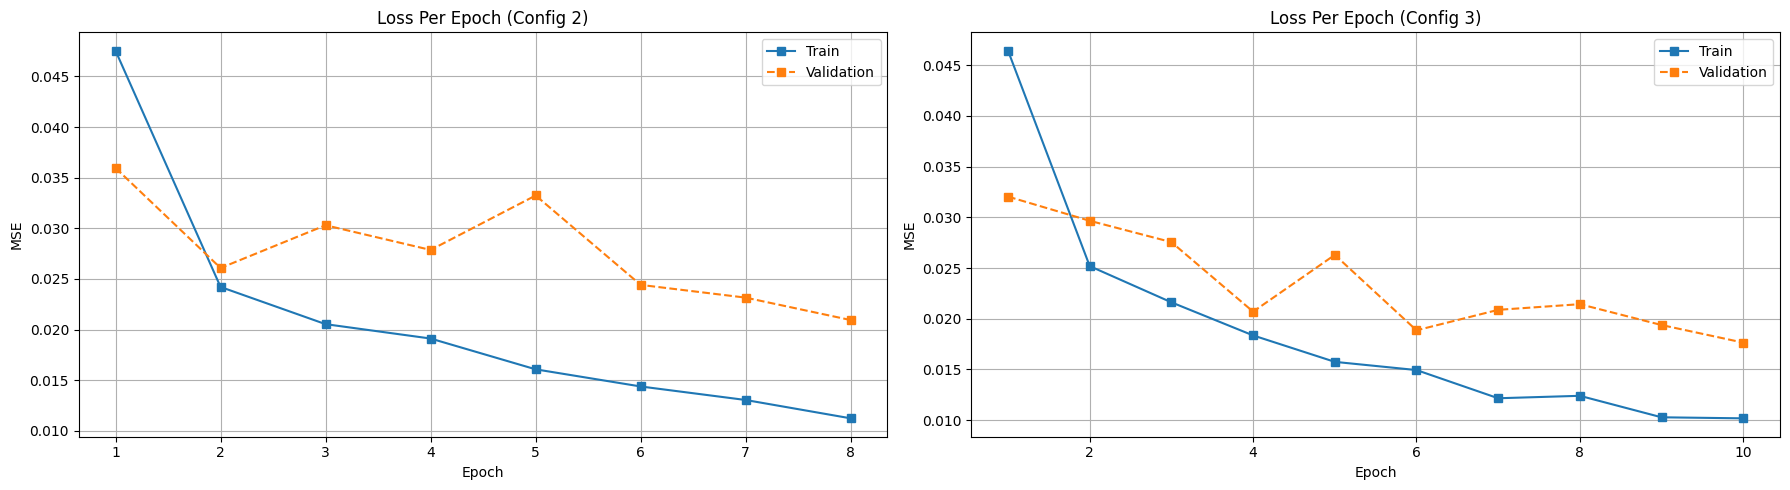

In [9]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 1 row, 3 columns

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


# Scatter Plot with Regression Line

In [10]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-lite-base-p2')
model = RegressionModel('indobenchmark/indobert-lite-base-p2', pooling_type='cls').to('cuda')
def predict(df_test, config_id):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/preprocessing/cross/bert_classifier_indo_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at indobenchmark/indobert-lite-base-p2 were not used when initializing AlbertModel: ['pooler.bias', 'pooler.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
import pandas as pd

df_config = pd.read_csv("bert_classifier_indo.csv")
df_config = df_config[2:]
df1 = df_config[df_config['dataset_type'] == 'before preprocessing']
df2 = df_config[df_config['dataset_type'] == 'after preprocessing']

# before preprocessing
df_test1 = pd.read_csv("../../../../data/cross/test_indo.csv")
for row in df1.itertuples():
    all_predictions, all_targets = predict(df_test1, row.config_id)

    # Tambahkan prediksi ke df_test
    df_test1[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test1, os.path.join(output_dir, "bert_predictions_indo1.csv"))

# after preprocessing
df_test2 = pd.read_csv("../../../../data/clean/cross/test_indo.csv")
for row in df2.itertuples():
    all_predictions, all_targets = predict(df_test2, row.config_id)

    # Tambahkan prediksi ke df_test
    df_test2[f"predicted_score_{row.config_id}"] = all_predictions

save_predictions(df_test2, os.path.join(output_dir, "bert_predictions_indo2.csv"))

c:\Users\User\Documents\Code\asas\modeling_albert_default.py:181: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attention_output = torch.nn.functional.scaled_dot_product_attention(



>> Before Preprocessing - predicted_score_2
RMSE: 0.1116, Pearson: 0.9292

>> After Preprocessing - predicted_score_3
RMSE: 0.1056, Pearson: 0.9167


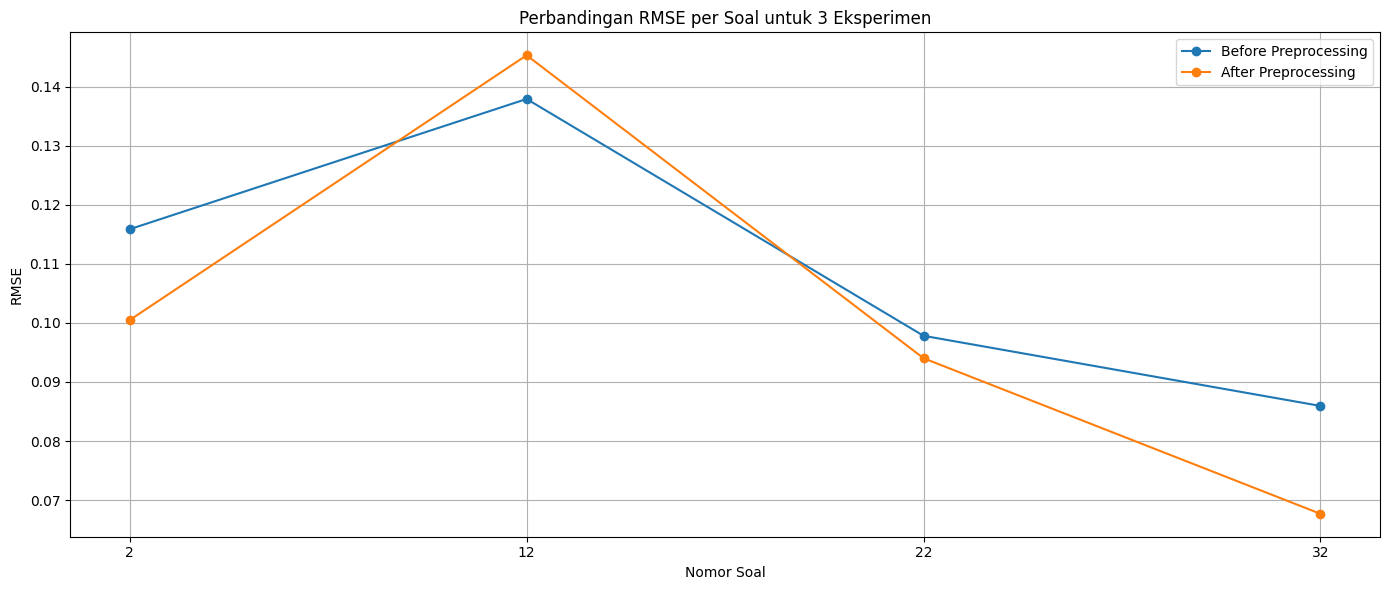

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

# Folder inference
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv")]

# Warna akan di-generate otomatis tergantung jumlah eksperimen
color_palette = plt.get_cmap("tab10")  # Bisa memuat hingga 10 warna berbeda

# Label eksperimen bisa ditentukan manual berdasarkan nama kolom prediksi
label_map = {
    "predicted_score_2": "Before Preprocessing",
    "predicted_score_3": "After Preprocessing",
}

# Dictionary untuk menyimpan RMSE per soal dari tiap eksperimen
rmse_per_model = {}

# Buat scatter plot dan hitung RMSE per soal
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        # Hitung metrik global
        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col)  # Default pakai nama kolom kalau tidak ditemukan
        print(f"\n>> {label} - {col}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        # Hitung RMSE per soal
        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

# Ekstrak nomor soal dari dataset_num (misalnya 'analisis_essay-19' -> 19)
def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

# Plot gabungan RMSE per soal
plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    # Ekstrak nomor soal
    soal_numbers = extract_soal_number(rmse_series.index)
    
    # Gabungkan kembali ke Series dengan index numerik
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    # Plot
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))  # Lebih rapi dan terbaca
plt.tight_layout()
plt.show()



In [7]:
fixed_threshold = 0.1

# Gabungkan semua residual untuk IQR Global
all_residual_values = []

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))
        all_residual_values.extend(residuals)

model_data = sorted(model_data, key=lambda x: x[0])

# Hitung IQR global
q1 = np.percentile(all_residual_values, 25)
q3 = np.percentile(all_residual_values, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Visualisasi scatter plot untuk tiap model
num_models = len(model_data)

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    # Deteksi outlier IQR global & fixed threshold
    outlier_iqr = (residuals < lower_bound) | (residuals > upper_bound)
    outlier_fixed = np.abs(residuals) > fixed_threshold

        # Hitung jumlah outlier
    num_outliers_iqr = np.sum(outlier_iqr)
    num_outliers_fixed = np.sum(outlier_fixed)

    # Cetak hasil
    print(f"{label}:")
    print(f"  Outlier (IQR Global): {num_outliers_iqr}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")

After Preprocessing:
  Outlier (IQR Global): 5
  Outlier (Fixed ±0.1): 64

Before Preprocessing:
  Outlier (IQR Global): 3
  Outlier (Fixed ±0.1): 82



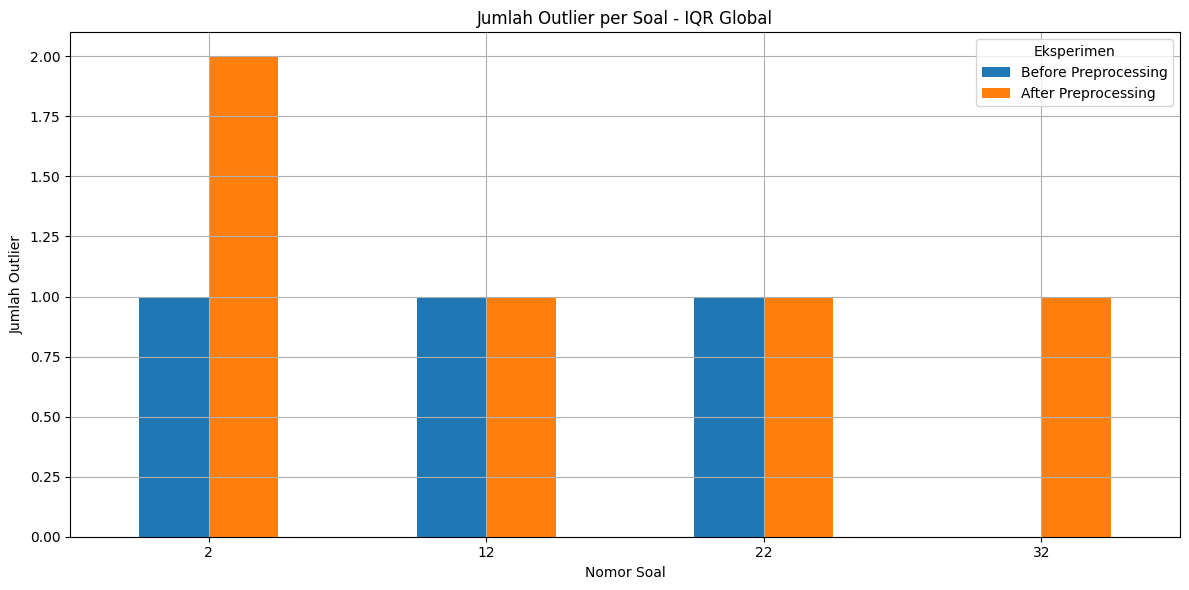


=== DATA OUTLIER BERDASARKAN IQR GLOBAL ===

IQR Outliers untuk eksperimen: Before Preprocessing
+-------------------+------------+---------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path ke folder berisi file CSV
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv")]

# Step 1: Hitung residual gabungan untuk IQR global
all_residuals = []
outlier_counts_iqr = {}
outlier_counts_fixed = {}

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        residuals = df[col].values - true_scores
        all_residuals.extend(residuals)

# Step 2: Hitung batas bawah dan atas global IQR
q1 = np.percentile(all_residuals, 25)
q3 = np.percentile(all_residuals, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Fixed threshold
fixed_threshold = 0.1

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_iqr = (residuals < lower_bound) | (residuals > upper_bound)
        outlier_mask_fixed = np.abs(residuals) > fixed_threshold

        df['outlier_iqr'] = outlier_mask_iqr
        df['outlier_fixed'] = outlier_mask_fixed

        label = label_map.get(col, col)

        # IQR Global
        iqr_counts = df[df['outlier_iqr']].groupby('soal_num').size()
        outlier_counts_iqr[label] = iqr_counts

        # Fixed Threshold
        fixed_counts = df[df['outlier_fixed']].groupby('soal_num').size()
        outlier_counts_fixed[label] = fixed_counts

# Step 4: Gabungkan ke DataFrame dan isi kosong dengan nol
df_iqr = pd.DataFrame(outlier_counts_iqr).fillna(0).astype(int).sort_index()
df_fixed = pd.DataFrame(outlier_counts_fixed).fillna(0).astype(int).sort_index()

# Plot 1: IQR Global
fig1, ax1 = plt.subplots(figsize=(12, 6))
df_iqr.plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal - IQR Global")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.grid(True)
ax1.legend(title="Eksperimen")
ax1.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

# # Plot 2: Fixed Threshold dengan ukuran lebih besar
# fig2, ax2 = plt.subplots(figsize=(18, 6))
# df_fixed.plot(kind='bar', ax=ax2)
# ax2.set_title("Jumlah Outlier per Soal - Threshold ±0.1")
# ax2.set_xlabel("Nomor Soal")
# ax2.set_ylabel("Jumlah Outlier")
# ax2.grid(True)
# ax2.legend(title="Eksperimen")
# ax2.tick_params(axis='x', rotation=0)
# plt.tight_layout()
# plt.show()

from tabulate import tabulate

# Tampilkan data outlier berdasarkan IQR Global
print("\n=== DATA OUTLIER BERDASARKAN IQR GLOBAL ===")
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores
        outlier_mask = (residuals < lower_bound) | (residuals > upper_bound)

        subset_iqr = df[outlier_mask][['dataset_num', 'soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
        # subset_iqr = subset_iqr[(subset_iqr['soal_num'] == 27) | (subset_iqr['soal_num'] == 29)]
        if not subset_iqr.empty:
            print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
            print(tabulate(subset_iqr, headers='keys', tablefmt='grid', showindex=False))


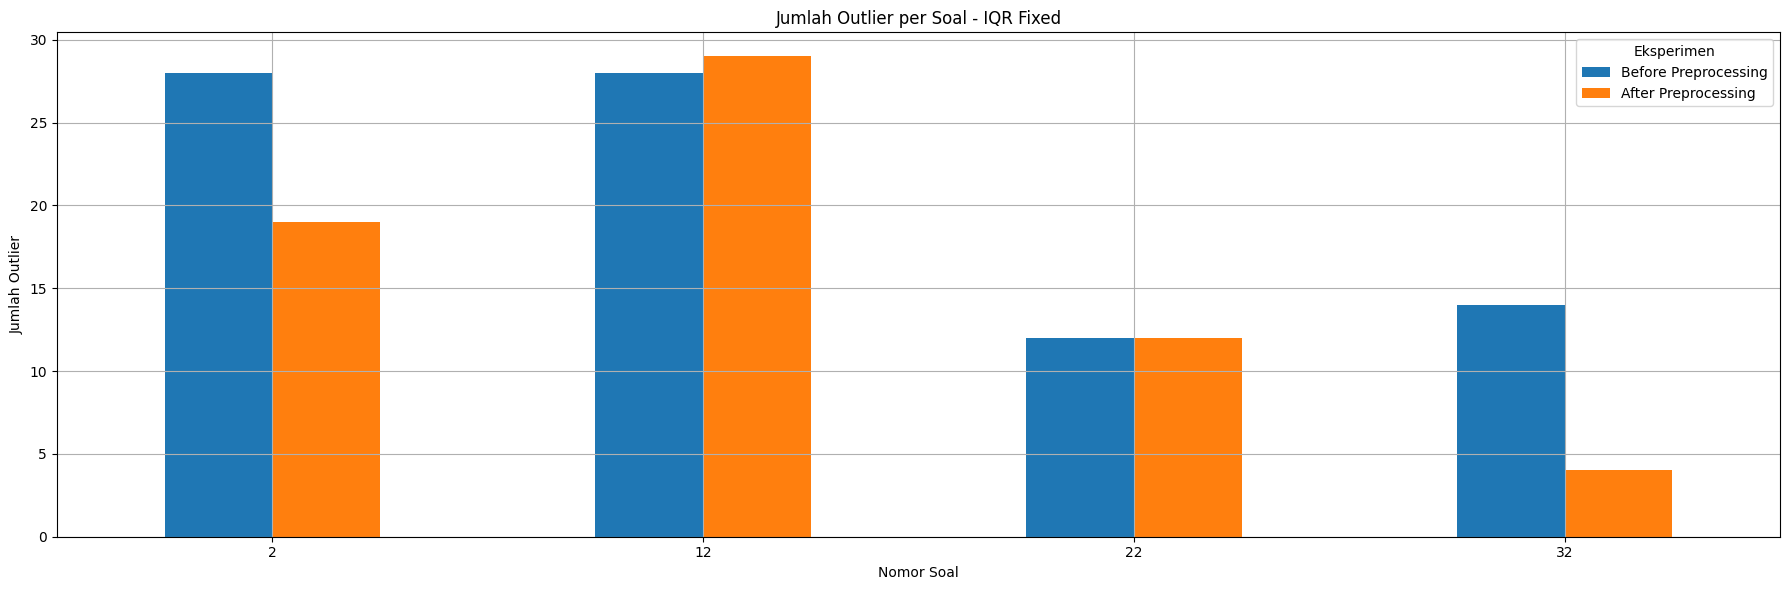


=== DATA OUTLIER BERDASARKAN IQR FIXED ===

IQR Outliers untuk eksperimen: Before Preprocessing
+-------------------+------------+-------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path ke folder berisi file CSV
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv")]

# Step 1: Hitung residual gabungan untuk IQR global
all_residuals = []
outlier_counts_iqr = {}
outlier_counts_fixed = {}

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        residuals = df[col].values - true_scores
        all_residuals.extend(residuals)

# Step 2: Hitung batas bawah dan atas global IQR
q1 = np.percentile(all_residuals, 25)
q3 = np.percentile(all_residuals, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Fixed threshold
fixed_threshold = 0.1

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_iqr = (residuals < lower_bound) | (residuals > upper_bound)
        outlier_mask_fixed = np.abs(residuals) > fixed_threshold

        df['outlier_iqr'] = outlier_mask_iqr
        df['outlier_fixed'] = outlier_mask_fixed

        label = label_map.get(col, col)

        # IQR Global
        iqr_counts = df[df['outlier_iqr']].groupby('soal_num').size()
        outlier_counts_iqr[label] = iqr_counts

        # Fixed Threshold
        fixed_counts = df[df['outlier_fixed']].groupby('soal_num').size()
        outlier_counts_fixed[label] = fixed_counts

# Step 4: Gabungkan ke DataFrame dan isi kosong dengan nol
df_iqr = pd.DataFrame(outlier_counts_iqr).fillna(0).astype(int).sort_index()
df_fixed = pd.DataFrame(outlier_counts_fixed).fillna(0).astype(int).sort_index()

# Plot 1: IQR Fixed
fig1, ax1 = plt.subplots(figsize=(18, 6))
df_fixed.plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal - IQR Fixed")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.grid(True)
ax1.legend(title="Eksperimen")
ax1.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

from tabulate import tabulate

# Tampilkan data outlier berdasarkan IQR Fixed
print("\n=== DATA OUTLIER BERDASARKAN IQR FIXED ===")
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores
        outlier_mask = np.abs(residuals) > fixed_threshold

        subset_iqr = df[outlier_mask][['dataset_num', 'soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
        # subset_iqr = subset_iqr[(subset_iqr['soal_num'] == 27) | (subset_iqr['soal_num'] == 29)]
        if not subset_iqr.empty:
            print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
            print(tabulate(subset_iqr, headers='keys', tablefmt='grid', showindex=False))
